In [1]:
import pandas as pd

In [4]:
df = pd.read_csv(r'boston_corrected.csv')

## Checking and cleaning the data

This data frame contains the following columns:

    TOWN a factor with levels given by town names
    Should all be strings
    All have capital letter at the beginning of each word

    TOWNNO a numeric vector corresponding to TOWN
    Should be int
    Should be same number as number of unique town names

    TRACT a numeric vector of tract ID numbers
    Should be int
    Should be >= 0

    LON a numeric vector of tract point longitudes in decimal degrees
    Should be float
    Should be between -180 and 180

    LAT a numeric vector of tract point latitudes in decimal degrees
    Should be float
    Should be between -90 and 90

    MEDV a numeric vector of median values of owner-occupied housing in USD 1000
    Should be float

    CMEDV a numeric vector of corrected median values of owner-occupied housing in USD 1000
    Should be float

    CRIM a numeric vector of per capita crime
    Should be float

    ZN a numeric vector of proportions of residential land zoned for lots over 25000 sq. ft per town (constant for all Boston tracts)
    Should be float

    INDUS a numeric vector of proportions of non-retail business acres per town (constant for all Boston tracts)
    Should be float

    CHAS a factor with levels 1 if tract borders Charles River; 0 otherwise
    Should be int

    NOX a numeric vector of nitric oxides concentration (parts per 10 million) per town
    Should be float

    RM a numeric vector of average numbers of rooms per dwelling
    Should be float

    AGE a numeric vector of proportions of owner-occupied units built prior to 1940
    Should be float

    DIS a numeric vector of weighted distances to five Boston employment centres
    Should be float

    RAD a numeric vector of an index of accessibility to radial highways per town (constant for all Boston tracts)
    Should be float

    TAX a numeric vector full-value property-tax rate per USD 10,000 per town (constant for all Boston tracts)
    Should be float

    PTRATIO a numeric vector of pupil-teacher ratios per town (constant for all Boston tracts)
    Should be float

    B a numeric vector of 1000*(Bk - 0.63)^2 where Bk is the proportion of blacks
    Should be float

    LSTAT a numeric vector of percentage values of lower status population
    Should be float
    
Adapted from: https://nowosad.github.io/spData/reference/boston.html

In [5]:
df.head()

,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


### Checking that there are no null values and that dtypes are as expected

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TOWN     506 non-null    object 
 1   TOWNNO   506 non-null    int64  
 2   TRACT    506 non-null    int64  
 3   LON      506 non-null    float64
 4   LAT      506 non-null    float64
 5   MEDV     506 non-null    float64
 6   CMEDV    506 non-null    float64
 7   CRIM     506 non-null    float64
 8   ZN       506 non-null    float64
 9   INDUS    506 non-null    float64
 10  CHAS     506 non-null    int64  
 11  NOX      506 non-null    float64
 12  RM       506 non-null    float64
 13  AGE      506 non-null    float64
 14  DIS      506 non-null    float64
 15  RAD      506 non-null    int64  
 16  TAX      506 non-null    int64  
 17  PTRATIO  506 non-null    float64
 18  B        506 non-null    float64
 19  LSTAT    506 non-null    float64
dtypes: float64(14), int64(5), object(1)
memory usage: 79.2

In [19]:
sorted(df.TOWN.unique())

['Arlington',
 'Ashland',
 'Bedford',
 'Belmont',
 'Beverly',
 'Boston Allston-Brighton',
 'Boston Back Bay',
 'Boston Beacon Hill',
 'Boston Charlestown',
 'Boston Dorchester',
 'Boston Downtown',
 'Boston East Boston',
 'Boston Forest Hills',
 'Boston Hyde Park',
 'Boston Mattapan',
 'Boston North End',
 'Boston Roxbury',
 'Boston Savin Hill',
 'Boston South Boston',
 'Boston West Roxbury',
 'Braintree',
 'Brookline',
 'Burlington',
 'Cambridge',
 'Canton',
 'Chelsea',
 'Cohasset',
 'Concord',
 'Danvers',
 'Dedham',
 'Dover',
 'Duxbury',
 'Everett',
 'Framingham',
 'Hamilton',
 'Hanover',
 'Hingham',
 'Holbrook',
 'Hull',
 'Lexington',
 'Lincoln',
 'Lynn',
 'Lynnfield',
 'Malden',
 'Manchester',
 'Marblehead',
 'Marshfield',
 'Medfield',
 'Medford',
 'Melrose',
 'Middleton',
 'Millis',
 'Milton',
 'Nahant',
 'Natick',
 'Needham',
 'Newton',
 'Norfolk',
 'North Reading',
 'Norwell',
 'Norwood',
 'Peabody',
 'Pembroke',
 'Quincy',
 'Randolph',
 'Reading',
 'Revere',
 'Rockland',
 'Sale

### Check that the characteristics of each column are as expected as defined above

In [30]:
assert len(df.TOWN.unique()) == len(df.TOWNNO.unique()), 'Number of unique town names must be equal to number of unique town numbers'

In [31]:
assert all(df.TRACT) >= 0, 'ID numbers must be greater than or equal to zero'

In [32]:
assert -180 <= all(df.LON) <= 180, 'Longitude must be between -180 and 180'

In [33]:
assert -90 <= all(df.LAT) <= 90, 'Latitude must be between -90 and 90'

In [ ]:
# FINISH ASSERTIONS

### Dropping the MEDV column as CMEDV will be used as our target variable and we do not want data leakage

In [41]:
df.drop('MEDV', axis=1, inplace=True)

## Feature engineering

In [35]:
import matplotlib.pyplot as plt

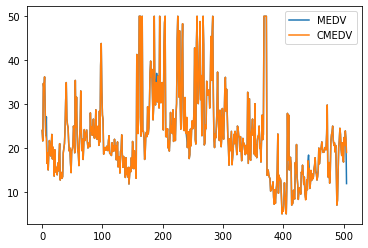

In [36]:
df.MEDV.plot(label='MEDV')
df.CMEDV.plot(label='CMEDV')
plt.legend()

<AxesSubplot:>

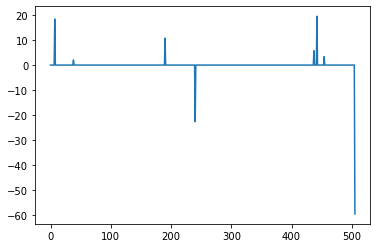

In [39]:
(100*(df.MEDV-df.CMEDV)/df.MEDV).plot()